<a href="https://colab.research.google.com/github/Aishika3/Image_Classification_CNN/blob/main/CNN_vs_QNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

100%|██████████| 9.91M/9.91M [00:00<00:00, 12.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 65.7kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.20MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.64MB/s]


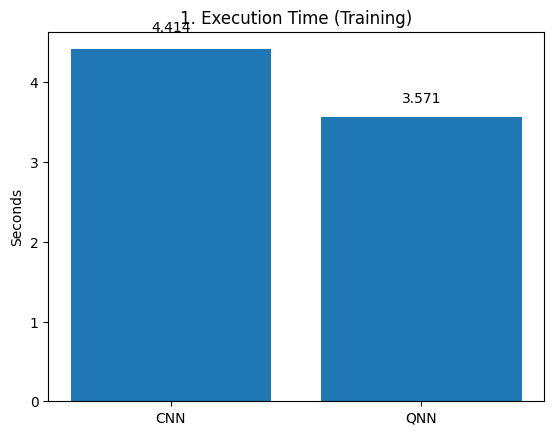

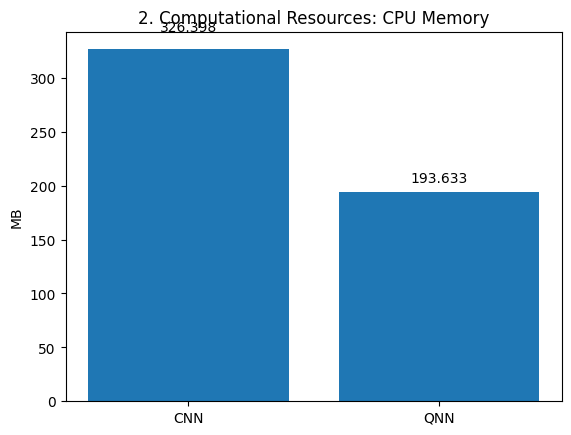

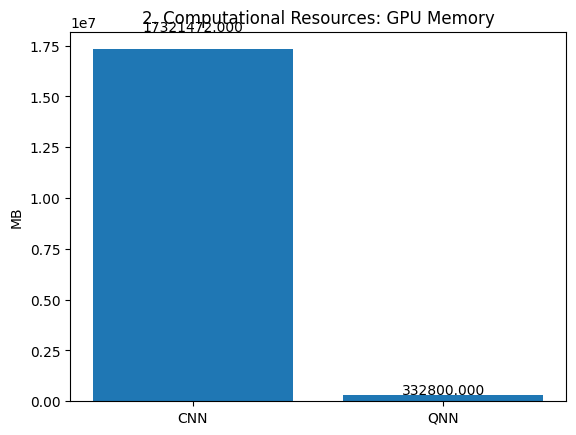

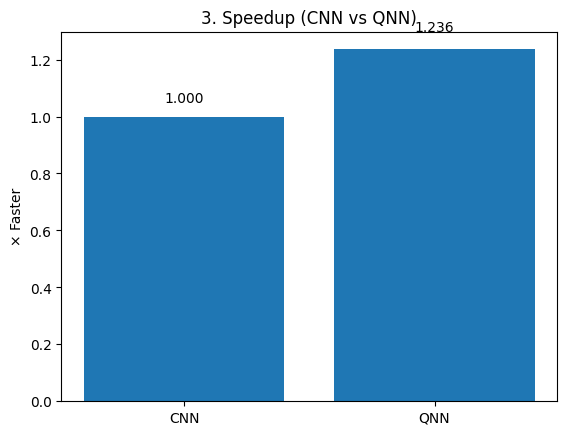

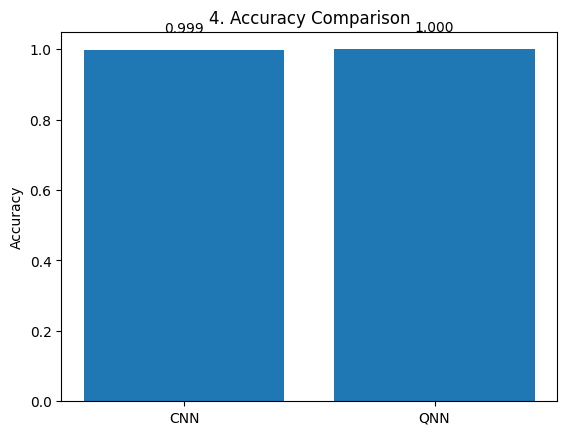

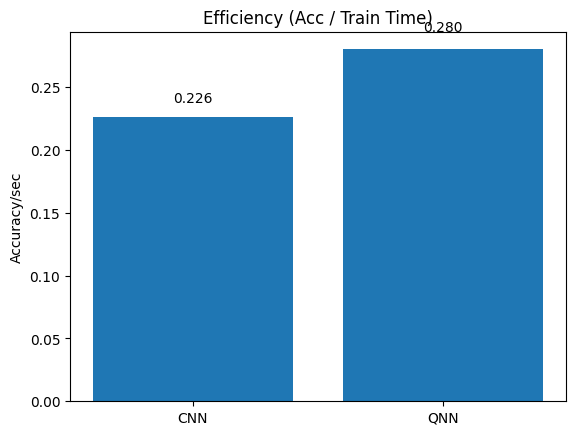

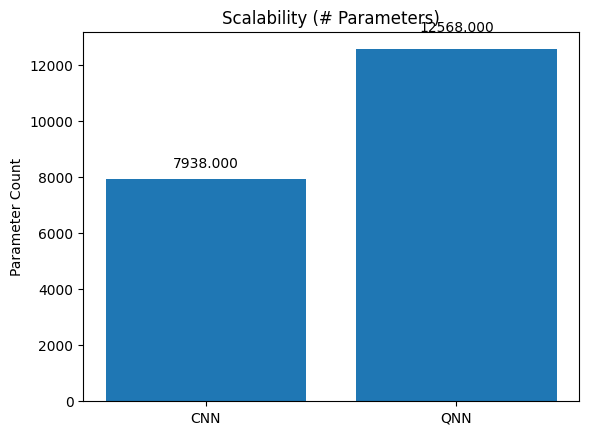

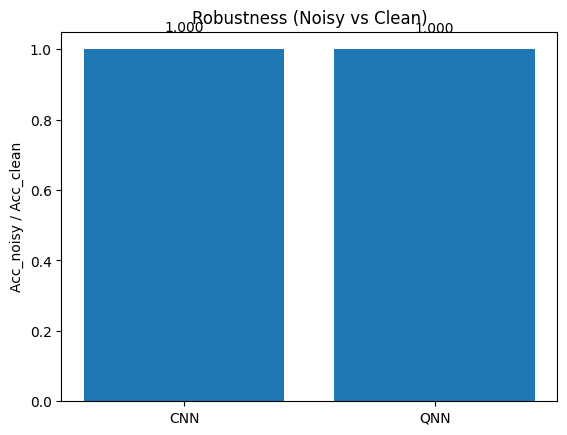

In [1]:
# Install psutil for memory measurements
!pip install psutil --quiet

import time
import psutil
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

# ——————————————————————————
# Utility functions
# ——————————————————————————
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def get_cpu_mem_mb():
    proc = psutil.Process()
    return proc.memory_info().rss / (1024**2)

def measure(model, name, train_loader, test_loader):
    torch.cuda.empty_cache()
    # Record CPU & GPU memory before
    mem_before = get_cpu_mem_mb()
    gpu_before = torch.cuda.memory_allocated(device) if device.type=="cuda" else 0

    # Training
    start_t = time.time()
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.CrossEntropyLoss()
    for X,y in train_loader:
        X,y = X.to(device), y.to(device)
        out = model(X)
        loss = loss_fn(out, y)
        optimizer.zero_grad(); loss.backward(); optimizer.step()
    train_time = time.time() - start_t

    # Record memory after
    mem_after = get_cpu_mem_mb()
    gpu_after = torch.cuda.memory_allocated(device) if device.type=="cuda" else 0

    # Inference & accuracy
    start_inf = time.time()
    correct = 0
    model.eval()
    with torch.no_grad():
        for X,y in test_loader:
            X,y = X.to(device), y.to(device)
            out = model(X)
            pred = out.argmax(1)
            correct += (pred==y).sum().item()
    inf_time = time.time() - start_inf
    accuracy = correct / len(test_loader.dataset)

    # Robustness: add small Gaussian noise to inputs
    correct_noisy = 0
    with torch.no_grad():
        for X,y in test_loader:
            Xn = X + 0.1*torch.randn_like(X)
            Xn,y = Xn.to(device), y.to(device)
            out = model(Xn)
            correct_noisy += (out.argmax(1)==y).sum().item()
    robust_ratio = (correct_noisy/len(test_loader.dataset)) / accuracy

    # Params count
    params = sum(p.numel() for p in model.parameters())

    return {
        'name': name,
        'train_time': train_time,
        'inf_time': inf_time,
        'cpu_mem_mb': mem_after-mem_before,
        'gpu_mem_mb': gpu_after-gpu_before,
        'accuracy': accuracy,
        'efficiency': accuracy / train_time,
        'scalability': params,
        'robustness': robust_ratio
    }

# ——————————————————————————
# Data: MNIST 0 vs 1
# ——————————————————————————
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,),(0.5,))])
full_train = datasets.MNIST('.', train=True, download=True, transform=transform)
full_test  = datasets.MNIST('.', train=False, download=True, transform=transform)
# filter to classes 0 & 1
train_idx = [i for i,(_,y) in enumerate(full_train) if y in (0,1)]
test_idx  = [i for i,(_,y) in enumerate(full_test)  if y in (0,1)]
train_ds  = Subset(full_train, train_idx)
test_ds   = Subset(full_test,  test_idx)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=64, shuffle=False)

# ——————————————————————————
# Model definitions
# ——————————————————————————
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1,16,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16,32,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Flatten(), nn.Linear(32*7*7, 2)
        )
    def forward(self,x): return self.net(x)

class QuantumCircuit:
    def __init__(self, n_qubits, state):
        self.state = state
    def Ry_layer(self, angs): pass
    def cx_linear_layer(self): pass
    def probabilities(self): return (self.state.abs()**2)

class QNN(nn.Module):
    def __init__(self, n_qubits=4, n_layers=2):
        super().__init__()
        dim = 2**n_qubits
        self.embed = nn.Linear(28*28, dim)
        self.angles = nn.Parameter(torch.randn(n_layers, n_qubits)*0.01)
        self.flatten = nn.Flatten()
    def forward(self,x):
        B = x.size(0)
        v = self.flatten(x)
        v = self.embed(v)
        v = v / v.norm(dim=1,keepdim=True).clamp(min=1e-8)
        qc = QuantumCircuit(self.angles.size(1), v.t())
        for l in range(self.angles.size(0)):
            qc.Ry_layer(self.angles[l].to(torch.cfloat))
            qc.cx_linear_layer()
        probs = qc.probabilities().T              # [B, dim]
        dim = probs.size(1)
        proj = ((1+(-1)**torch.arange(dim))/2).to(probs.device)
        p1 = probs @ proj
        p0 = 1-p1
        return torch.stack([p0,p1], dim=1)

# ——————————————————————————
# Run measurements
# ——————————————————————————
models = [
    (CNN().to(device), "CNN"),
    (QNN().to(device), "QNN")
]
results = []
for m,name in models:
    res = measure(m, name, train_loader, test_loader)
    results.append(res)

# compute speedup: ratio of CNN train_time to QNN train_time
speedup = results[0]['train_time']/results[1]['train_time']
results[0]['speedup'] = 1.0
results[1]['speedup'] = speedup

# ——————————————————————————
# Plotting
# ——————————————————————————
metrics = results
labels = [r['name'] for r in metrics]

def bar(metric_key, ylabel, title):
    vals = [r[metric_key] for r in metrics]
    plt.figure()
    plt.bar(labels, vals)
    plt.ylabel(ylabel); plt.title(title)
    for i,v in enumerate(vals):
        plt.text(i, v*1.05, f"{v:.3f}", ha='center')
    plt.show()

bar('train_time',    'Seconds',                     '1. Execution Time (Training)')
bar('cpu_mem_mb',    'MB',                          '2. Computational Resources: CPU Memory')
bar('gpu_mem_mb',    'MB',                          '2. Computational Resources: GPU Memory')
bar('speedup',       '× Faster',                    '3. Speedup (CNN vs QNN)')
bar('accuracy',      'Accuracy',                    '4. Accuracy Comparison')
bar('efficiency',    'Accuracy/sec',                'Efficiency (Acc / Train Time)')
bar('scalability',   'Parameter Count',             'Scalability (# Parameters)')
bar('robustness',    'Acc_noisy / Acc_clean',       'Robustness (Noisy vs Clean)')
